In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg

<IPython.core.display.Javascript object>


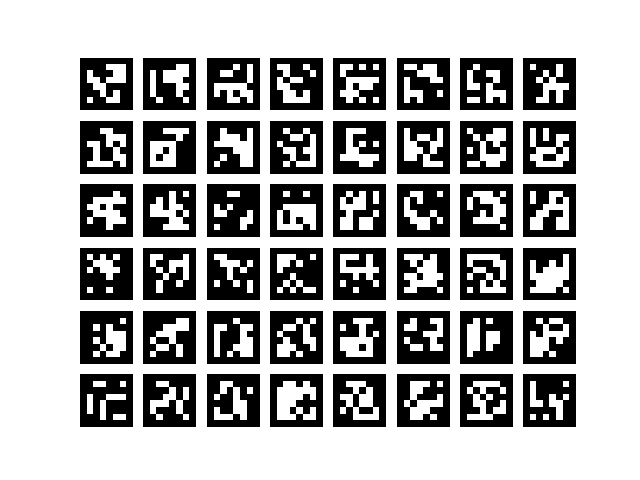

In [2]:
# imagesFolder = "~/Documents/HIWI/trajectory_tracking"

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

fig = plt.figure()
nx = 8
ny = 6
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i-1, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig("markers.pdf")    
plt.show()
#plt.close()

In [2]:
board = aruco.CharucoBoard_create(3, 3, 1, 0.8, aruco_dict)
imboard = board.draw((4000, 4000))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
cv2.imwrite(imagesFolder + "/chessboard.tiff",imboard)
plt.savefig("chessboard.pdf")   
plt.grid()
plt.show()
print("print it out for calibration!")

NameError: name 'aruco_dict' is not defined

In [6]:
import cv2
import math

videoFile = "aruco_camera_calibration.mp4"
imagesFolder = "camera_cali"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId <100):
        filename = imagesFolder + "/image_" +  str(int(frameId)) + ".jpg"
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [7]:
im = PIL.Image.open(imagesFolder + "/image_0.jpg")
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
ax.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'camera_cali/image_0.jpg'

In [49]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    
    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        res = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(res[0])>0:
            res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              

        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize
    print("finished")

In [50]:
#%%time
images = [imagesFolder + '/' + f for f in os.listdir(imagesFolder) if f.startswith("image_")]

allCorners,allIds,imsize=read_chessboards(images)



POSE ESTIMATION STARTS:
=> Processing image camera_cali/image_44.jpg
=> Processing image camera_cali/image_36.jpg
=> Processing image camera_cali/image_58.jpg
=> Processing image camera_cali/image_4.jpg
=> Processing image camera_cali/image_42.jpg
=> Processing image camera_cali/image_81.jpg
=> Processing image camera_cali/image_71.jpg
=> Processing image camera_cali/image_52.jpg
=> Processing image camera_cali/image_54.jpg
=> Processing image camera_cali/image_77.jpg
=> Processing image camera_cali/image_8.jpg
=> Processing image camera_cali/image_99.jpg
=> Processing image camera_cali/image_40.jpg
=> Processing image camera_cali/image_80.jpg
=> Processing image camera_cali/image_60.jpg
=> Processing image camera_cali/image_26.jpg
=> Processing image camera_cali/image_97.jpg
=> Processing image camera_cali/image_73.jpg
=> Processing image camera_cali/image_82.jpg
=> Processing image camera_cali/image_78.jpg
=> Processing image camera_cali/image_64.jpg
=> Processing image camera_cali/i

In [51]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors
    print("finished")

In [52]:
%%time
ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)
ret

CAMERA CALIBRATION
CPU times: user 1min 15s, sys: 0 ns, total: 1min 15s
Wall time: 1min 15s


0.1341607877998243

In [53]:
mtx


array([[1.99832227e+03, 0.00000000e+00, 5.42349522e+02],
       [0.00000000e+00, 2.00024973e+03, 9.59132791e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [54]:
dist

array([[ 0.17977459],
       [-0.26966188],
       [ 0.02202856],
       [-0.01437217],
       [-0.30844436],
       [-0.16817612],
       [ 0.18680968],
       [-0.12614992],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [61]:
mtx_read = np.loadtxt("camera_cali/calib_mtx_webcam.csv")

camera_cali/calib_mtx_webcam.csv


In [55]:
np.savetxt(imagesFolder+"/calib_mtx_webcam.csv", mtx)
np.savetxt(imagesFolder+"/calib_dist_webcam.csv", dist)

## Check calibration 

<IPython.core.display.Javascript object>


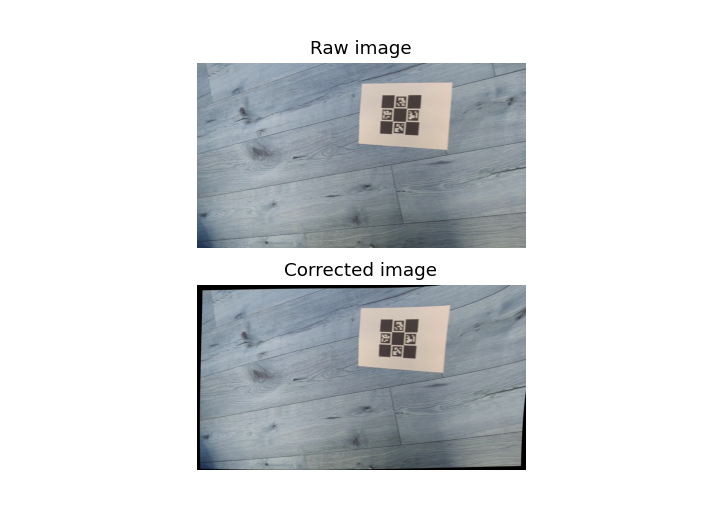

In [56]:
i=24 # select image id
plt.figure()
frame = cv2.imread(imagesFolder + "/image_77.jpg".format(i))
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(211)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(212)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

# Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

<IPython.core.display.Javascript object>


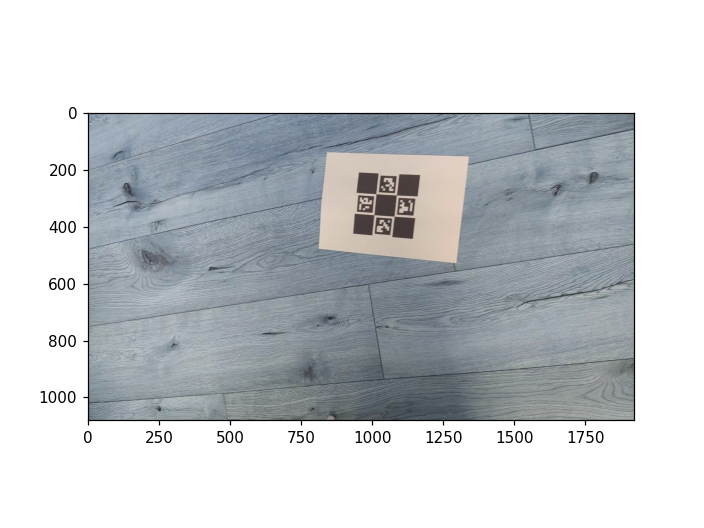

In [57]:
frame = cv2.imread(imagesFolder + "/image_63.jpg")
plt.figure()
plt.imshow(frame)
plt.show()

# Post processing

In [58]:
%%time

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

CPU times: user 121 ms, sys: 145 µs, total: 121 ms
Wall time: 43.7 ms


# Result

<IPython.core.display.Javascript object>


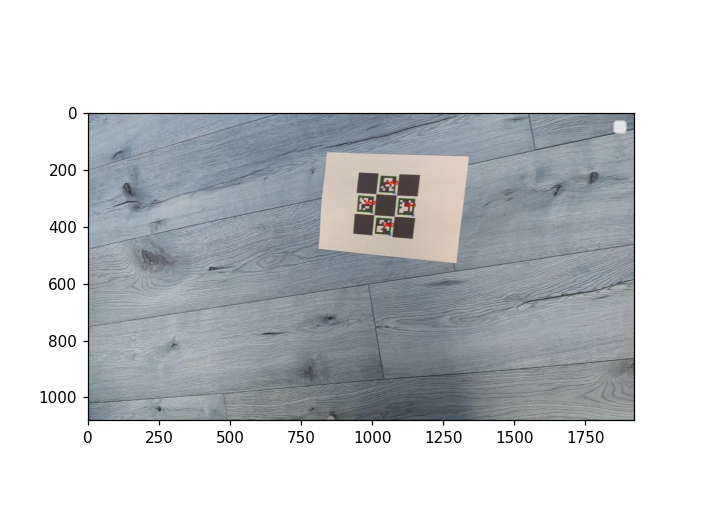

No handles with labels found to put in legend.


In [59]:
conn = np.array([0, 1, 2, 3, 0])
plt.figure()
plt.imshow(frame_markers)
plt.legend()
plt.show()

### Add local axis on each maker

In [41]:
size_of_marker =  0.0345 # side lenght of the marker in meter
rvecs,tvecs, trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

In [30]:
tvecs.shape

(4, 1, 3)

In [31]:
np.degrees(rvecs)

array([[[  -6.74955184,  163.58698969,   35.69421161]],

       [[  11.47255683, -167.52594053,   -4.01852365]],

       [[  -6.36056914,  167.17373196,   40.72067285]],

       [[  12.86150107, -165.66682498,   -4.99311323]]])

In [32]:
length_of_axis = 0.01
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

<IPython.core.display.Javascript object>


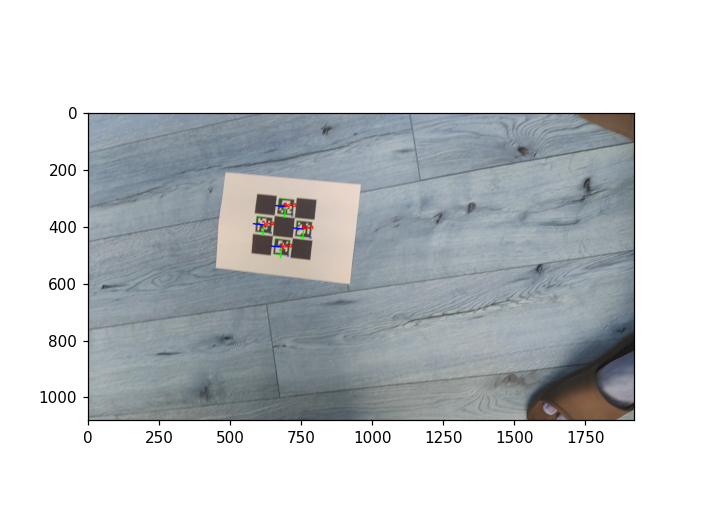

In [35]:
plt.figure()
plt.imshow(imaxis)
plt.show()

In [34]:
data=pd.DataFrame(data=tvecs.reshape(43,3),columns=["tx","ty","tz"],index=ids.flatten())
data.index.name="makers"
data.sort_index(inplace=True)
data

ValueError: cannot reshape array of size 12 into shape (43,3)

In [55]:
p=data.values
((p[1]-p[0])**2.).sum()**.5,((p[2]-p[1])**2.).sum()**.5,((p[3]-p[2])**2.).sum()**.5

(0.04309652659780655, 0.041190101023714003, 0.043743470242086288)

In [56]:
((data.loc[11]-data.loc[0]).values**2).sum()

0.001743801337263979

In [57]:
V0_1= p[1]-p[0]
V0_11=p[11]-p[0]
V0_1,V0_11

(array([ 0.0427035 ,  0.00074629, -0.00575889]),
 array([ 0.04097137,  0.04177   ,  0.00013852]))

In [58]:
np.dot(V0_1,V0_11)

0.0017799953347752665

<IPython.core.display.Javascript object>


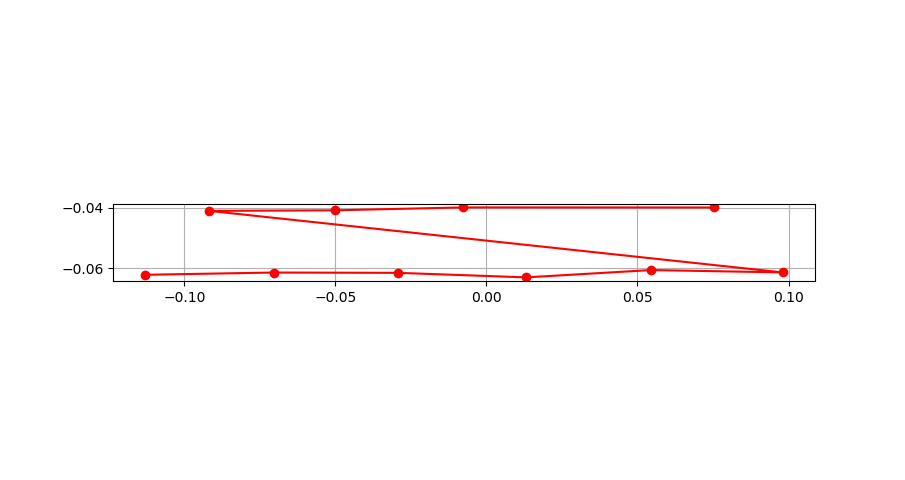

In [59]:
fig=plt.figure()
ax= fig.add_subplot(1,1,1)
ax.set_aspect("equal")
plt.plot(data.tx[:10], data.ty[:10],"or-")
plt.grid()
plt.show()

In [ ]:
data.tx

In [60]:
corners=np.array(corners)
data2=pd.DataFrame({"px":corners[:,0,0,1],"py":corners[:,0,0,0]},index=ids.flatten())
data2.sort_index(inplace=True)

data2

,px,py
0,229.0,335.0
1,230.0,465.0
2,230.0,595.0
3,231.0,729.0
4,231.0,861.0
5,232.0,995.0
6,316.0,399.0
7,317.0,530.0
8,318.0,662.0
10,319.0,928.0


In [61]:
n0=data2.loc[0]
n1=data2.loc[1]
d01=((n0-n1).values**2).sum()**.5
d=42.5e-3
factor=d/d01
data2["x"]=data2.px*factor
data2["y"]=data2.py*factor
d1_0=data2.loc[2].y-data2.loc[1].y
d11_0=data2.loc[11].x-data2.loc[0].x
d1_0


0.042498738

In [62]:
d11_0

0.057536766

In [19]:
imagesFolder = "E:\Desktop\S8\Projet 851\data"
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
board = cv2.aruco.CharucoBoard_create(3,3,.025,.0125,dictionary)
img = board.draw((200*3,200*3))
cv2.imwrite(imagesFolder + '\charucotest.png',img)


True

In [8]:
help (aruco)

Help on module cv2.aruco in cv2:

NAME
    cv2.aruco

FUNCTIONS
    Board_create(...)
        Board_create(objPoints, dictionary, ids) -> retval
        .   * @brief Provide way to create Board by passing nessesary data. Specially needed in Python.
        .   *
        .   * @param objPoints array of object points of all the marker corners in the board
        .   * @param dictionary the dictionary of markers employed for this board
        .   * @param ids vector of the identifiers of the markers in the board
        .   *
    
    CharucoBoard_create(...)
        CharucoBoard_create(squaresX, squaresY, squareLength, markerLength, dictionary) -> retval
        .   * @brief Create a CharucoBoard object
        .   *
        .   * @param squaresX number of chessboard squares in X direction
        .   * @param squaresY number of chessboard squares in Y direction
        .   * @param squareLength chessboard square side length (normally in meters)
        .   * @param markerLength marker

In [ ]:
charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9)

In [28]:
help (aruco.calibrateCameraCharucoExtended)

Help on built-in function calibrateCameraCharuco:

calibrateCameraCharuco(...)
    calibrateCameraCharuco(charucoCorners, charucoIds, board, imageSize, cameraMatrix, distCoeffs[, rvecs[, tvecs[, flags[, criteria]]]]) -> retval, cameraMatrix, distCoeffs, rvecs, tvecs
    .   @brief It's the same function as #calibrateCameraCharuco but without calibration error estimation.

